<a href="https://colab.research.google.com/github/lucywowen/CDL-bibliography/blob/master/arch_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nltools
!pip install nilearn
!pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 39.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.3 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
sc

In [ ]:
%pylab inline
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.io import loadmat
import nilearn as nl             # pip: nilearn==0.10.0
import nibabel as nib
import nltools as nlt
from matplotlib.colors import ListedColormap



Populating the interactive namespace from numpy and matplotlib


In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
import scipy
import numpy as np


################################################################################
# Archetypal Analysis        ####################################################
################################################################################
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin


class ArchetypalAnalysis(BaseEstimator, TransformerMixin):

    def __init__(self, n_archetypes=None, tmax=20, iterations=10):
        '''
        Implements archetypal analysis
            Archetypal Analysis as an Autoencoder (Bauckhage et al. 2015)

        Parameters
        ----------

        n_archetypes : the number of archetype

        tmax : the number of iterations of the derivative update

        iterations : the number of iterations of the overall algorithm


        Notes
        ---------

        The matrices have the following dimensions (following the above paper)
        [X] - m x n
        [Z] - m x k
        [B] - n x k
        [A] - k x n
        [e_A] - k x 1
        [e_B] - n x 1

        Source: https://miller-blog.com/archetypal-analysis/

        '''
        self.n_archetypes = n_archetypes
        self.tmax = tmax
        self.iterations = iterations

        N = self.n_archetypes
        x, y = np.zeros(N), np.zeros(N)
        x[1:] = np.cumsum(np.cos(np.arange(0, N - 1) * 2 * np.pi / N))
        y[1:] = np.cumsum(np.sin(np.arange(0, N - 1) * 2 * np.pi / N))
        self.map2D = np.vstack((x, y))

    def fit(self, X, y=None):
        """Fit the model with X using Archetypal Analysis
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : Ignored
        Returns
        -------
        self : object
            Returns the instance itself.

        Source: https://miller-blog.com/archetypal-analysis/
        """
        self._fit(X)
        return self

    def _fit(self, X):
        k = self.n_archetypes
        m, n = X.shape

        B = np.eye(n, k)
        Z = X @ B

        for i in range(self.iterations):
            A = self._computeA(X, Z, self.tmax)
            B = self._computeB(X, A, self.tmax)
            Z = X @ B
            print('RSS = {}'.format(self._rss(X, A, Z)))

        self.Z_ = Z
        self.A_ = A

    def _computeA(self, X, Z, tmax):
        '''
        Algorithm 1 of Bauckhage et al. 2015
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        m, n = X.shape
        k = self.n_archetypes

        A = np.zeros((k, n))
        A[0, :] = 1.0
        for t in range(tmax):
            # brackets are important to get reasonable sizes
            # [G] ~  k x n
            G = 2.0 * ((Z.T @ Z) @ A - Z.T @ X)
            # Get the argument mins along each column
            argmins = np.argmin(G, axis=0)
            e = np.zeros(G.shape)
            e[argmins, range(n)] = 1.0
            A += 2.0 / (t + 2.0) * (e - A)
        return A

    def _computeB(self, X, A, tmax):
        '''
        Algorithm 2 of Bauckhage et al. 2015
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        k, n = A.shape
        B = np.zeros((n, k))
        B[0, :] = 1.0
        for t in range(tmax):
            # brackets are important to get reasonable sizes
            t1 = X.T @ (X @ B) @ (A @ A.T)
            t2 = X.T @ (X @ A.T)
            G = 2.0 * (t1 - t2)
            argmins = np.argmin(G, axis=0)
            e = np.zeros(G.shape)
            e[argmins, range(k)] = 1.0
            B += 2.0 / (t + 2.0) * (e - B)
        return B

    def archetypes(self):
        '''
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        return self.Z_

    def transform(self, X):
        '''
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        return self._computeA(X, self.Z_, self.tmax)

    def inverse_transform(self, X):

        return np.dot(self.Z_, X.T).T

    def _rss(self, X, A, Z):
        '''
        Source: https://miller-blog.com/archetypal-analysis/
        '''
        return np.linalg.norm(X - Z @ A)

    def score(self, X):

        X = X.T
        return -self._rss(X, self.A_, self.Z_)

def archetypal_plot(ax, data, dp, epsilon=0.2):
    '''
    Source: Dr. Luke Bovard
    '''
    ax.scatter(data[0, :], data[1, :], alpha=0.6, linewidths=10)
    ax.scatter(dp[0, :], dp[1, :], c='orange')

    for i in range(dp.shape[1]):
        if dp[0, i] < 0.5:
            eps_x = -epsilon
        else:
            eps_x = epsilon
        if dp[1, i] < np.max(dp[1, :]) / 2.0:
            eps_y = -epsilon
        else:
            eps_y = epsilon
        ax.text(dp[0, i] + eps_x, dp[1, i] + eps_y, "{}".format(i + 1))
    return ax

In [ ]:

import warnings
from nilearn.maskers import NiftiMasker


def nii2cmu(nifti_file, mask_file=None):
    '''
    inputs:
      nifti_file: a filename of a .nii or .nii.gz file to be converted into
                  CMU format

      mask_file: a filename of a .nii or .nii.gz file to be used as a mask; all
                 zero-valued voxels in the mask will be ignored in the CMU-
                 formatted output.  If ignored or set to None, no voxels will
                 be masked out.

    outputs:
      Y: a number-of-timepoints by number-of-voxels numpy array containing the
         image data.  Each row of Y is an fMRI volume in the original nifti
         file.

      R: a number-of-voxels by 3 numpy array containing the voxel locations.
         Row indices of R match the column indices in Y.
    '''
    def fullfact(dims):
        '''
        Replicates MATLAB's fullfact function (behaves the same way)
        '''
        vals = np.asmatrix(range(1, dims[0] + 1)).T
        if len(dims) == 1:
            return vals
        else:
            aftervals = np.asmatrix(fullfact(dims[1:]))
            inds = np.asmatrix(np.zeros((np.prod(dims), len(dims))))
            row = 0
            for i in range(aftervals.shape[0]):
                inds[row:(row + len(vals)), 0] = vals
                inds[row:(row + len(vals)), 1:] = np.tile(aftervals[i, :], (len(vals), 1))
                row += len(vals)
            return inds

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        if type(nifti_file) == str:
            img = nib.load(nifti_file)
        elif type(nifti_file) == nib.nifti1.Nifti1Image:
            img = nifti_file
        else:
            raise ValueError('nifti_file must be a filename or nibabel Nifti1Image object')

        mask = NiftiMasker(mask_strategy='background')
        if mask_file is None:
            mask.fit(nifti_file)
        else:
            mask.fit(mask_file)

    hdr = img.header
    S = img.get_sform()
    vox_size = hdr.get_zooms()
    im_size = img.shape

    if len(img.shape) > 3:
        N = img.shape[3]
    else:
        N = 1

    Y = np.float32(mask.transform(nifti_file)).copy()
    vmask = np.nonzero(np.array(np.reshape(mask.mask_img_.dataobj, (1, np.prod(mask.mask_img_.shape)), order='C')))[1]
    vox_coords = fullfact(img.shape[0:3])[vmask, ::-1]-1

    R = np.array(np.dot(vox_coords, S[0:3, 0:3])) + S[:3, 3]

    return {'Y': Y, 'R': R}

def cmu2nii(Y, R, template=None):
    '''
    inputs:
      Y: a number-of-timepoints by number-of-voxels numpy array containing the
         image data.  Each row of Y is an fMRI volume in the original nifti
         file.

      R: a number-of-voxels by 3 numpy array containing the voxel locations.
         Row indices of R match the column indices in Y.

      template: a filename of a .nii or .nii.gz file to be used as an image
                template.  Header information of the outputted nifti images will
                be read from the header file.  If this argument is ignored or
                set to None, header information will be inferred based on the
                R array.

    outputs:
      nifti_file: a filename of a .nii or .nii.gz file to be converted into
                  CMU format

      mask_file: a filename for a .nii or .nii.gz file to be used as a mask; all
                 zero-valued voxels in the mask will be ignored in the CMU-
                 formatted output

    outputs:
      img: a nibabel Nifti1Image object containing the fMRI data
    '''
    Y = np.array(Y, ndmin=2)
    img = nib.load(template)
    S = img.affine
    locs = np.array(np.dot(R - S[:3, 3], np.linalg.inv(S[0:3, 0:3])), dtype='int')

    data = np.zeros(tuple(list(img.shape)[0:3]+[Y.shape[0]]))

    # loop over data and locations to fill in activations
    for i in range(Y.shape[0]):
        for j in range(R.shape[0]):
            data[locs[j, 0], locs[j, 1], locs[j, 2], i] = Y[i, j]

    return nib.Nifti1Image(data, affine=img.affine)

def node_labels(centers, widths, networks_cmu):
    labels = []
    for c, w in zip(centers, widths):
        r = rbf(networks_cmu['R'], c, w)

        label_weights = [sum(r[networks_cmu['Y'].ravel() == i]) for i in range(1, len(network_codes) + 1)]
        labels.append(np.argmax(label_weights) + 1)

    return pd.DataFrame({'code': labels, 'Network': [list(lookup_table.values())[i - 1] for i in labels]})

def rbf(R, center, width):
    return np.exp(-np.sum((R - center) ** 2, axis=1) / width)

# Here's a mini analysis with some example fmri data

RSS = 2825.335809020158
RSS = 2805.797327332113
RSS = 2773.9391172169617
RSS = 2748.017565026116
RSS = 2740.4174937339717
RSS = 2738.1275177305893
RSS = 2736.711994044268
RSS = 2735.66718519486
RSS = 2734.9781362462977
RSS = 2734.465009369784


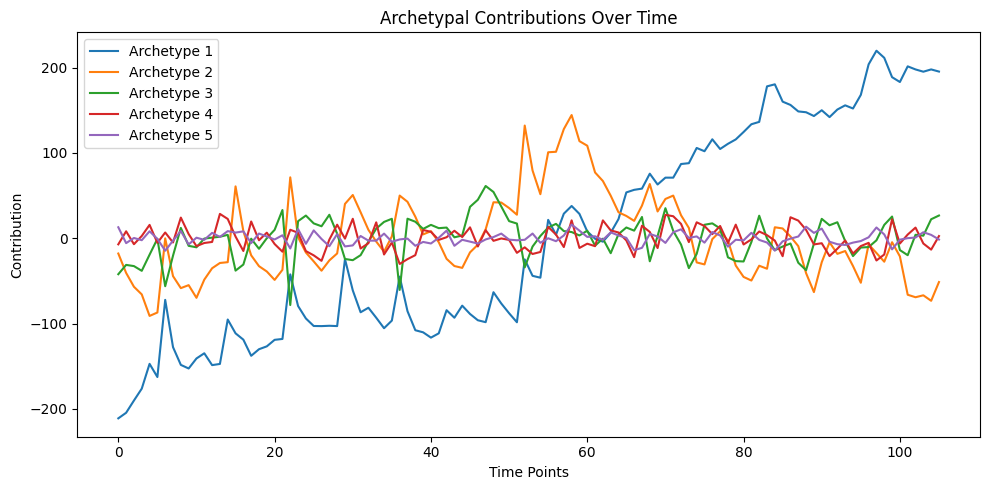

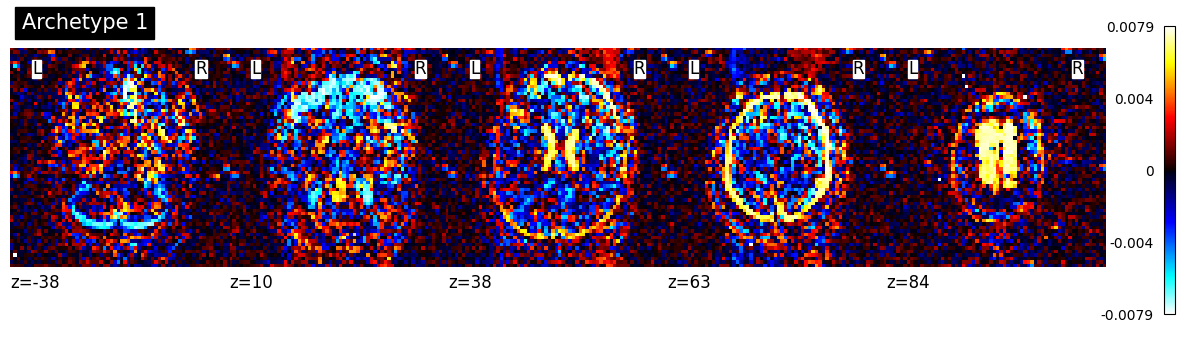

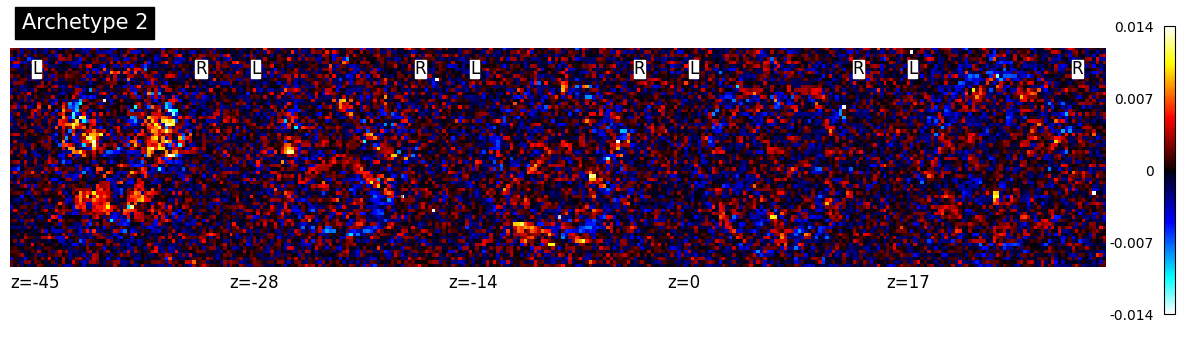

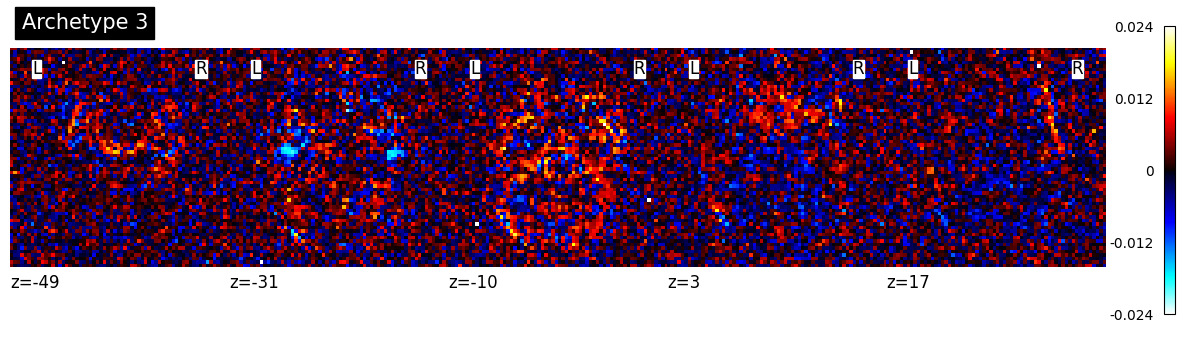

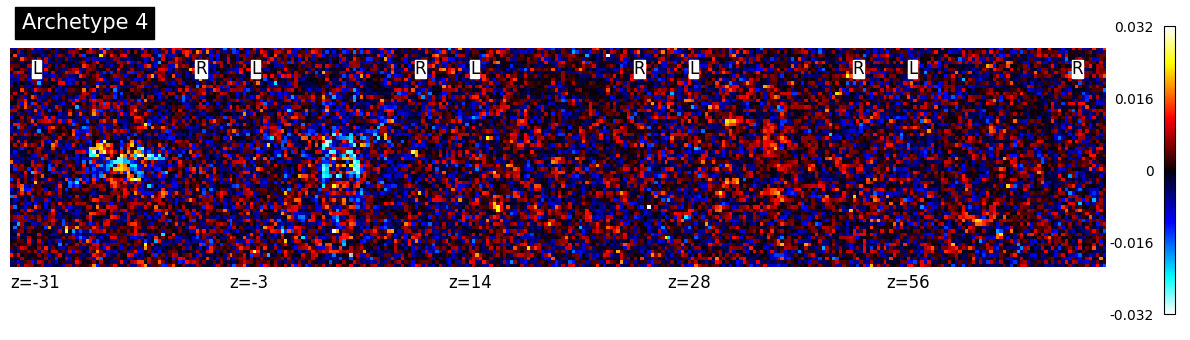

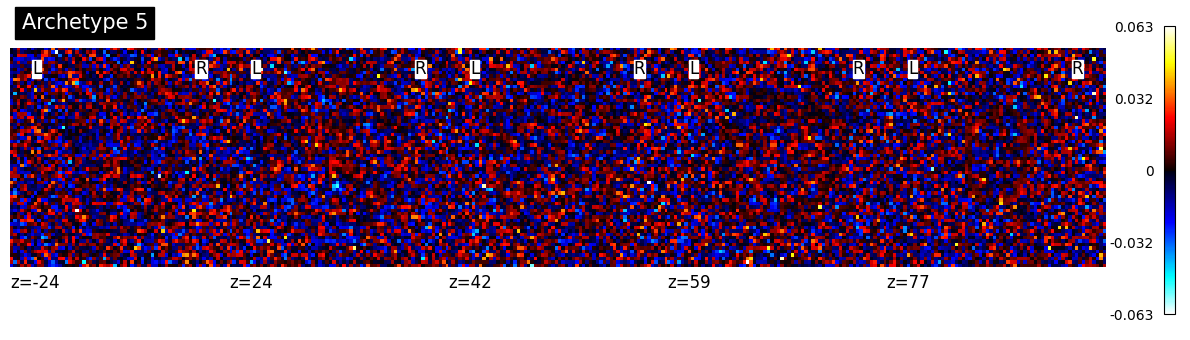

In [ ]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
from sklearn.decomposition import PCA

# Load fMRI data

img = nib.load('fmri.nii.gz')

# Mask and standardize the data
masker = NiftiMasker(standardize=True)
fmri_data = masker.fit_transform(img)  # Shape: (timepoints, voxels)

# Optional: Reduce dimensionality to speed up AA
pca = PCA(n_components=50)
reduced_data = pca.fit_transform(fmri_data)

# Archetypal Analysis
archs = ArchetypalAnalysis(n_archetypes=5,iterations=10,tmax=300) #only doing 10 iterations now to save on time
archs.fit(reduced_data)

# Get the archetypes and coefficients
archetypes = archs.transform(reduced_data)  # shape: (5, 50)
coeffs = archs.archetypes()           # shape: (n_samples, 5)

# Plot contribution of archetypes over time
plt.figure(figsize=(10, 5))
for i in range(coeffs.shape[1]):
    plt.plot(coeffs[:, i], label=f'Archetype {i+1}')
plt.xlabel('Time Points')
plt.ylabel('Contribution')
plt.title('Archetypal Contributions Over Time')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Transform archetypes back to voxel space (via PCA inverse -> masker inverse)
archetypes_voxel_space = pca.inverse_transform(archetypes)
archetype_imgs = masker.inverse_transform(archetypes_voxel_space)

# Plot one slice per archetype
from nilearn.plotting import plot_stat_map
for i in range(5):
    plot_stat_map(archetype_imgs.slicer[..., i], title=f'Archetype {i+1}', display_mode='z', cut_coords=5)


# Pie Man Data

## Load the data here

The data we're using for this, to start, is fMRI data from particpants scanned while being told a story in different listening conditions.  The story was told either intact, or scrambled by the paragraph, or scrambled by the word, or just while the participant was quietly resting.  

The fMRI data was then reduced using Hierarchicaly topographic factor analysis (HTFA which is a Bayesian factor analysis model designed to analyze brain network dynamics in multi-subject datasets. It builds upon Topographic Factor Analysis (TFA), extending it to incorporate data from multiple subjects, allowing for the identification of shared brain network hubs and the comparison of individual subject's brain activity against a global template. In this case, the >100,000 voxels was reduced to 700 nodes with varying widths.




In [ ]:
pieman_name = 'pieman_data.mat'
pieman_data = loadmat(pieman_name)
pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [ ]:
posterior = loadmat('pieman_posterior_K700.mat')
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

These lines of code separate the participant data by listening conditions (and skips over one participant with an incorrect number of timepoints in the paragraph condition)

In [ ]:
data = []
conds = []
for c in pieman_conds:
    if c == 'paragraph':
        next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
    else:
        next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
    data.extend(next_data)
    conds.extend([c]*len(next_data))


In [ ]:
conds_array = np.array(conds)

First, lets just play with some of the intact listening condition data:

In [ ]:
intact_list = [data[i] for i in np.where(conds_array=='intact')[0]]

In [ ]:
intact_array = np.array(intact_list)

And lets perform an archetypal analysis on just the first participant in that group:

RSS = 469.870802912148
RSS = 451.860174620089
RSS = 448.311991800234
RSS = 446.708491986472
RSS = 445.99106079051523
RSS = 445.68800699084125
RSS = 445.5330436393097
RSS = 445.43158774574977
RSS = 445.3532796461606
RSS = 445.2908001648331


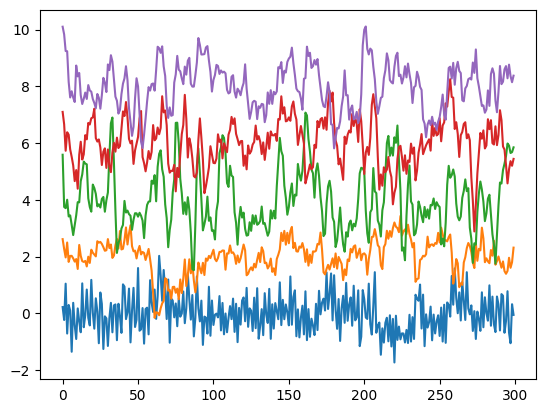

In [ ]:
archs = ArchetypalAnalysis(n_archetypes=5,iterations=10,tmax=300) #only doing 10 iterations now to save on time

archs.fit(intact_array[0])

Z=(archs.archetypes())

for i in np.arange(5):
  plt.plot(Z[:, i]+ 2*i)


TO DO: I'll need to do some experimenting with multiple `k` and `i` values to minimize these RSS values.

So my understanding is, running it this way, that these are the distinct characteristic *timeseries*  for this data. And the associated nodes that correspond to these timeseries would be in this `archs.A_` array, which is a `(5,700)` (the closer to 1, the more it is associated with the archetype, right??).

In [ ]:
np.isclose(archs.A_,1)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In order to achieve the archetypes on a network level, we first have to transform the results by calling the transform function and passing in the initial input dataset (the first participant in the intact group). This returns us the 5 archetypes for the timeseries.

In order to plot the results, we have to call multiple functions on the results from the AA: archs. This shows us the distribution of the nodes and where clusters were identified:

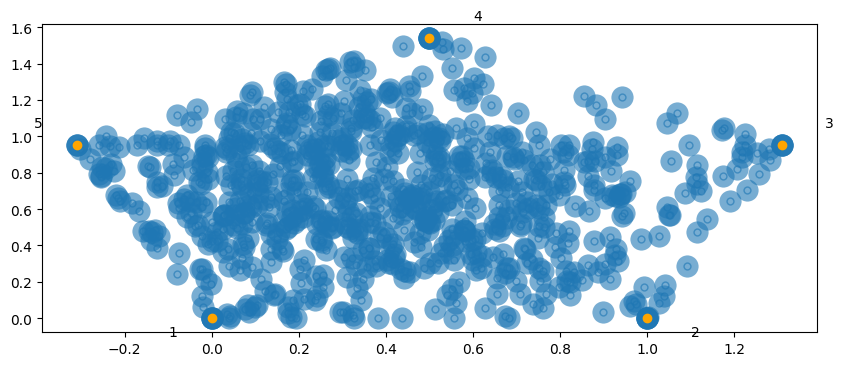

In [ ]:
A=archs.transform(intact_array[0])
dp=archs.map2D
dat=dp @ A

f, ax = plt.subplots(figsize=(10, 4))
ax=archetypal_plot(ax,dat,dp,epsilon=.1)
ax.set_aspect('auto')
plt.show()

Let's load in what we need for our network analysis:

In [ ]:
key = os.path.join('Schaefer2018_1000Parcels_7Networks_order.txt')
key = pd.read_csv(key, sep='\t', header=None, names=['id', 'name', 'x', 'y', 'z', 't']).drop('t', axis=1)
key['study'] = key['name'].apply(lambda x: x.split('_')[0])
key['hemisphere'] = key['name'].apply(lambda x: x.split('_')[1][0])
key['network'] = key['name'].apply(lambda x: x.split('_')[2])
key.drop('name', axis=1, inplace=True)

lookup_table = {
    'Vis': 'Visual',
    'SomMot': 'Somatomotor',
    'DorsAttn': 'Dorsal attention',
    'SalVentAttn': 'Ventral attention',
    'Limbic': 'Limbic',
    'Cont': 'Frontoparietal',
    'Default': 'Default mode'
}

network_colors = {
    'Visual': '#D7DF23',
    'Somatomotor': '#39B54A',
    'Dorsal attention': '#00A79D',
    'Ventral attention': '#27AAE1',
    'Limbic': '#1C75BC',
    'Frontoparietal': '#92278F',
    'Default mode': '#EE2A7B'
}

colors = ['#888888']
colors.extend([v for k, v in network_colors.items()])
network_cmap = ListedColormap(colors, N=len(colors)*2, name='networks')  # why do I need to double the number of colors?

network_codes = {k: i + 1 for i, k in enumerate(lookup_table.values())}

key['network'] = key['network'].apply(lambda x: lookup_table[x])
key['code'] = key['network'].apply(lambda x: network_codes[x])
key.set_index('id', inplace=True)
key.loc[0, 'code'] = 0  # append a background (non-network) code
key           # pip: nibabel==5.0.1

x      y      z      study hemisphere         network  code
id                                                                   
1     120.0   14.0  127.0  7Networks          L          Visual   1.0
2     120.0   14.0  128.0  7Networks          L          Visual   1.0
3     120.0   14.0  129.0  7Networks          L          Visual   1.0
4     120.0   14.0  130.0  7Networks          L          Visual   1.0
5     120.0   14.0  131.0  7Networks          L          Visual   1.0
...     ...    ...    ...        ...        ...             ...   ...
997   208.0   65.0   82.0  7Networks          R    Default mode   7.0
998   208.0   65.0   83.0  7Networks          R    Default mode   7.0
999   235.0  149.0   37.0  7Networks          R  Frontoparietal   6.0
1000  235.0  149.0   38.0  7Networks          R  Frontoparietal   6.0
0       NaN    NaN    NaN        NaN        NaN             NaN   0.0

[1001 rows x 7 columns]

In [ ]:
nii_fname = os.path.join('Schaefer2018_1000Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')


So this is a plot of the 7 networks in the brain determined by Yeo et al. (2017).  

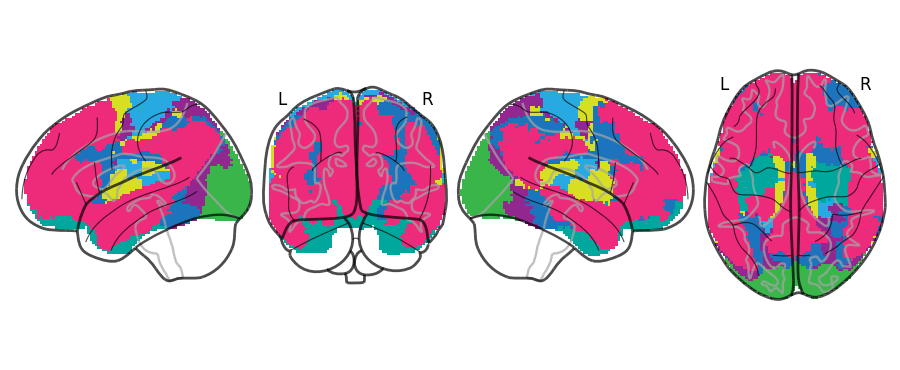

In [ ]:
nx = nlt.Brain_Data(nii_fname)
nx.data = np.array([key.loc[i, 'code'] for i in nx.data]).astype(float)
networks = nx.to_nifti()

fname = os.path.join('networks.pdf')
nl.plotting.plot_glass_brain(networks, cmap=network_cmap, display_mode='lyrz', output_file=fname)

# also display figure here
nl.plotting.plot_glass_brain(networks, cmap=network_cmap, display_mode='lyrz')

We need a way to map our 700 nodes to these networks:

In [ ]:
# load network parcellations in CMU format
networks_cmu = nii2cmu(nii_fname)

# covert voxel values in the reference image to network codes
networks_cmu['Y'] = np.atleast_2d(np.array([key.loc[i, 'code'] for i in networks_cmu['Y']]).astype(float))

And these are the labels/code for each of those nodes:

In [ ]:
node_codes = node_labels(centers, widths, networks_cmu)
node_codes

code            Network
0       4  Ventral attention
1       3   Dorsal attention
2       1             Visual
3       6     Frontoparietal
4       4  Ventral attention
..    ...                ...
695     2        Somatomotor
696     4  Ventral attention
697     4  Ventral attention
698     4  Ventral attention
699     6     Frontoparietal

[700 rows x 2 columns]

Ok and plot that now (we could vary the node size relative to the width, but just for simplicity the nodes are all the same size here).

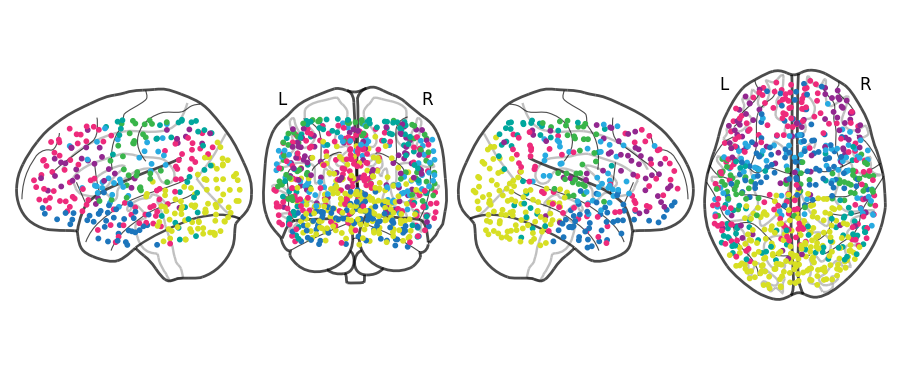

In [ ]:
nl.plotting.plot_connectome(np.eye(centers.shape[0]), centers, node_size=10, node_color=[colors[i] for i in node_codes['code']], display_mode='lyrz', output_file=os.path.join('htfa.pdf'))
nl.plotting.plot_connectome(np.eye(centers.shape[0]), centers, node_size=10, node_color=[colors[i] for i in node_codes['code']], display_mode='lyrz')

Ok now that we have the network labels for each of those nodes, lets see the overall count for each of those nodes in this dataset:

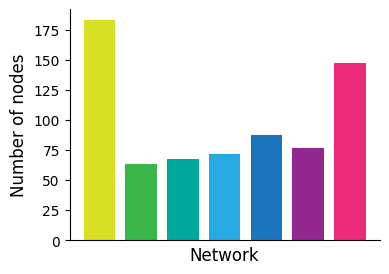

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes, x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

fig.savefig(os.path.join('htfa_node_counts.pdf'), bbox_inches='tight')

## Archetypes in 1 participant:

OK OK now back to the archetypal analysis... first let's just plot the timeseries and the corresponding nodes for the first archetype.  Remember, this is for that high frequency timeseries.

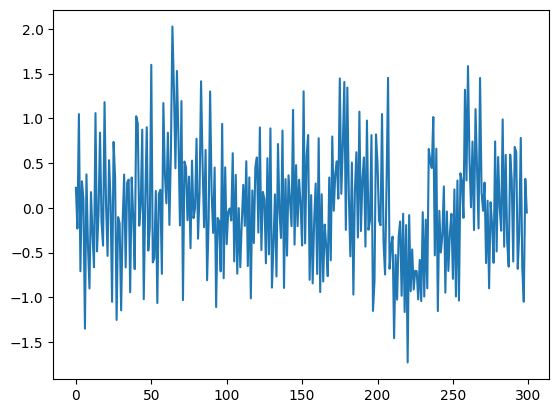

In [ ]:
plt.plot(Z[:, 0])

In [ ]:
locs_arch_1 = A[0]>.75

In [ ]:
arch_1_centers = centers[locs_arch_1]
arch_1_codes = node_codes['code'][locs_arch_1]
arch_1_nets = node_codes['Network'][locs_arch_1]

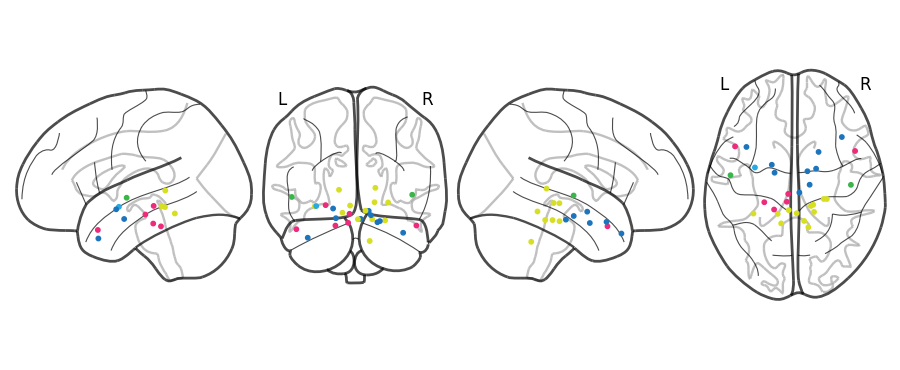

In [ ]:
nl.plotting.plot_connectome(np.eye(arch_1_centers.shape[0]), arch_1_centers, node_size=10, node_color=[colors[i] for i in arch_1_codes], display_mode='lyrz')

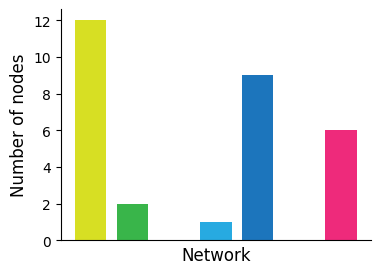

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes[locs_arch_1], x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

So this is interesting because it looks like the majority of these nodes are in the visual network... but you'll notice they are in the high level visual processing areas... as well as ventral attention and default mode.

Here's the same figures but for the second archetype... this has a slower frequency with a large dip around the 2 minute mark (this data was collected using 2 TRs, so the total time is 10 minutes).

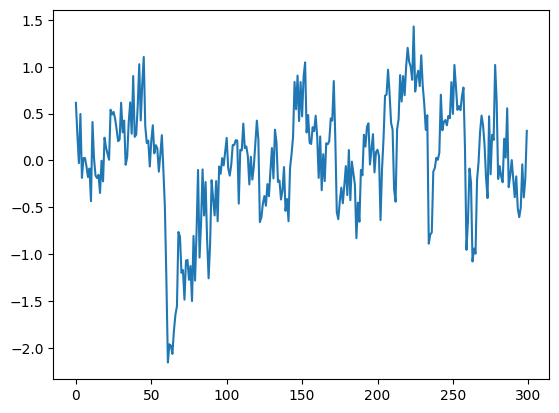

In [ ]:
plt.plot(Z[:, 1])

In [ ]:
locs_arch_2 = A[1]>.75

In [ ]:
arch_2_centers = centers[locs_arch_2]
arch_2_codes = node_codes['code'][locs_arch_2]
arch_2_nets = node_codes['Network'][locs_arch_2]

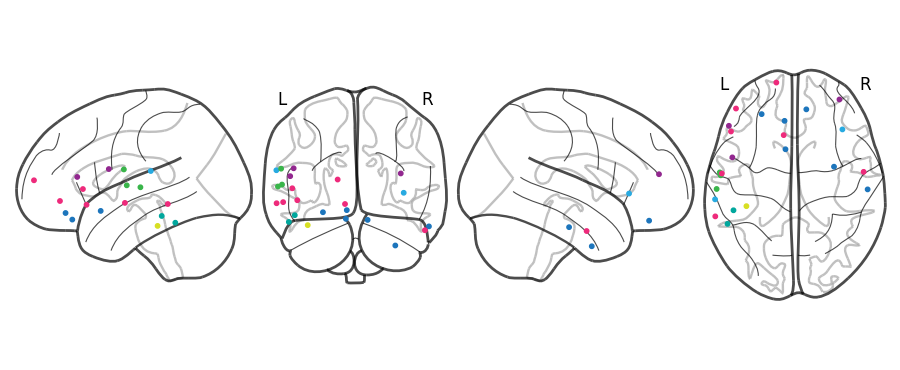

In [ ]:
nl.plotting.plot_connectome(np.eye(arch_2_centers.shape[0]), arch_2_centers, node_size=10, node_color=[colors[i] for i in arch_2_codes], display_mode='lyrz')

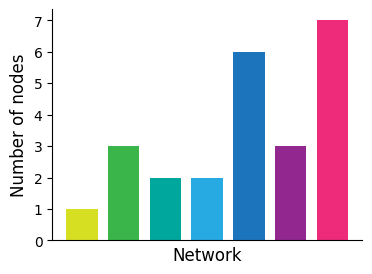

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes[locs_arch_2], x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

Looks like the majority of the nodes are in, again, the ventral attention and default mode networks. This is also picking up on *left* hemispheric nodes, particularly in the somatomotor network, and it really looks like they are in the speech and language processing areas!


Ok lets do it for the third archetype:

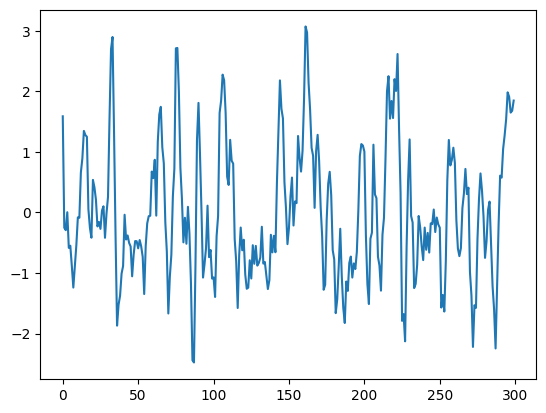

In [ ]:
plt.plot(Z[:, 2])

This is a very slow, variable signal... hmmm.. if we go this route with the timeseries I need to dig up a better way of quantifying these signals.  

In [ ]:
locs_arch_3 = A[2]>.75
arch_3_centers = centers[locs_arch_3]
arch_3_codes = node_codes['code'][locs_arch_3]
arch_3_nets = node_codes['Network'][locs_arch_3]

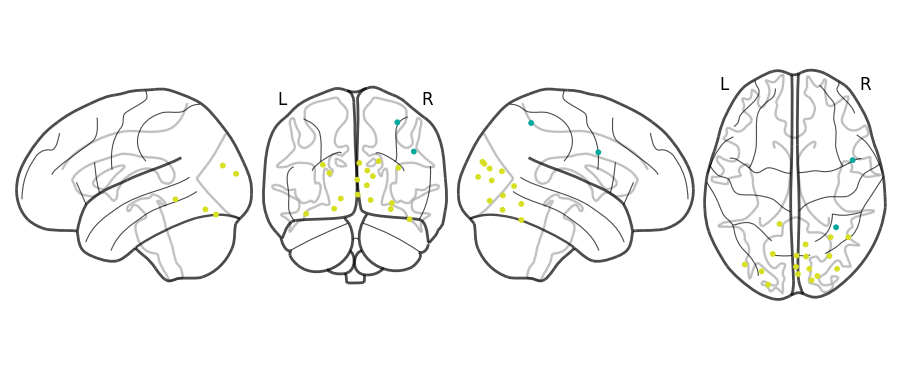

In [ ]:
nl.plotting.plot_connectome(np.eye(arch_3_centers.shape[0]), arch_3_centers, node_size=10, node_color=[colors[i] for i in arch_3_codes], display_mode='lyrz')

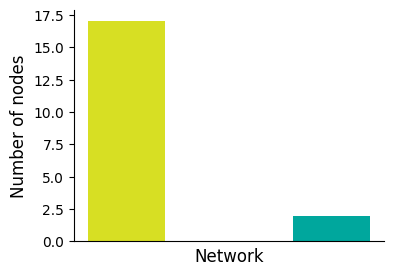

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes[locs_arch_3], x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

This ones cool, because it is almost entirely in the visual network.

Ok on to the fourth:

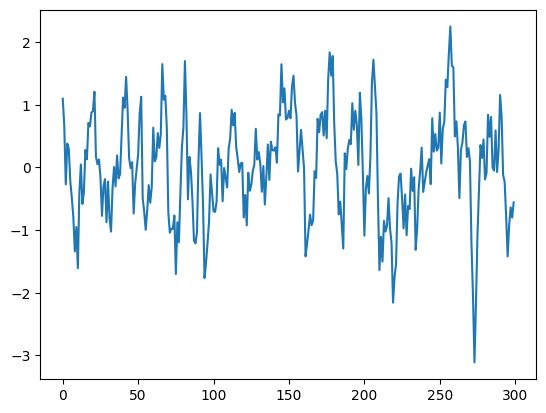

In [ ]:
plt.plot(Z[:, 3])

In [ ]:
locs_arch_4 = A[3]>.75
arch_4_centers = centers[locs_arch_4]
arch_4_codes = node_codes['code'][locs_arch_4]
arch_4_nets = node_codes['Network'][locs_arch_4]

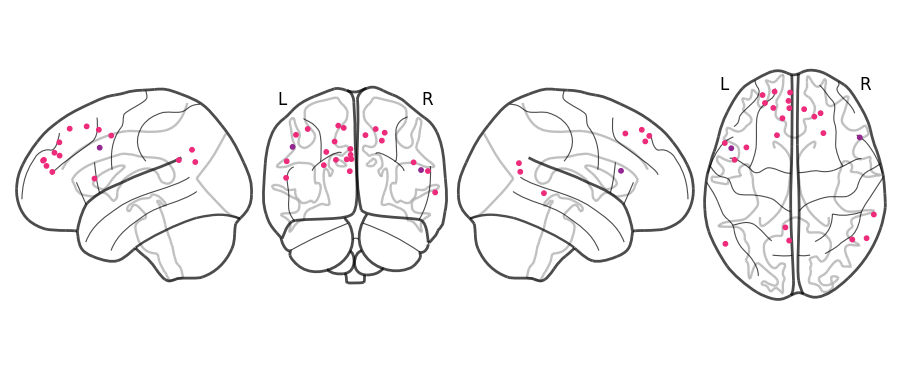

In [ ]:
nl.plotting.plot_connectome(np.eye(arch_4_centers.shape[0]), arch_4_centers, node_size=10, node_color=[colors[i] for i in arch_4_codes], display_mode='lyrz')

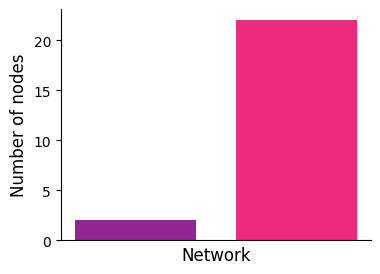

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes[locs_arch_4], x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

This is almost entirely in the default mode network! Ok and now the last one:

In [ ]:
locs_arch_5 = A[4]>.75
arch_5_centers = centers[locs_arch_5]
arch_5_codes = node_codes['code'][locs_arch_5]
arch_5_nets = node_codes['Network'][locs_arch_5]

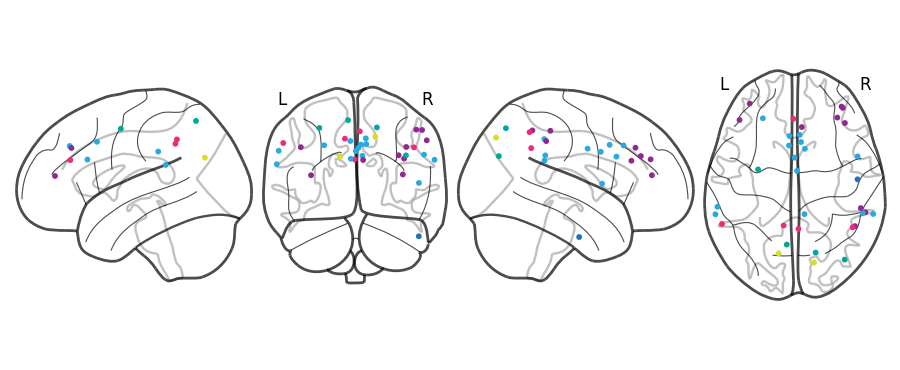

In [ ]:
nl.plotting.plot_connectome(np.eye(arch_5_centers.shape[0]), arch_5_centers, node_size=10, node_color=[colors[i] for i in arch_5_codes], display_mode='lyrz')

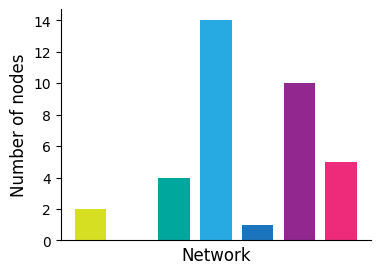

In [ ]:
fig = plt.figure(figsize=(4, 3))
ax = plt.gca()

sns.histplot(data=node_codes[locs_arch_5], x='code', color='k', shrink=0.75, hue='code', hue_order=range(1, 8), palette=colors[1:], alpha=1.0, legend=False, ax=ax, discrete=True, edgecolor=None)
ax.set_xlabel('Network', fontsize=12)
ax.set_ylabel('Number of nodes', fontsize=12)

ax.set_xticks([])
ax.spines[['right', 'top']].set_visible(False)

Kind of a smattering, but mainly in the ventral attention, frontoparietal (control), and default mode networks. Overall, very cool!

### Ok now lets try the same thing... but this time of the characteristic *nodes* by transposing the input data

RSS = 490.8364997530973
RSS = 471.6638124667698
RSS = 465.41325991006596
RSS = 463.012339570985
RSS = 461.4736327012403
RSS = 460.1260416176151
RSS = 459.26758579819256
RSS = 458.7769873772435
RSS = 458.52715352248566
RSS = 458.39394461701534


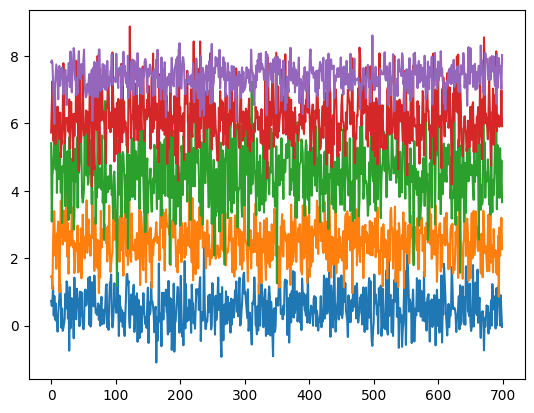

In [ ]:
archs = ArchetypalAnalysis(n_archetypes=5,iterations=10,tmax=300)

archs.fit(intact_array[0].T)

Z=(archs.archetypes())

for i in np.arange(5):
  plt.plot(Z[:, i]+ 2*i)


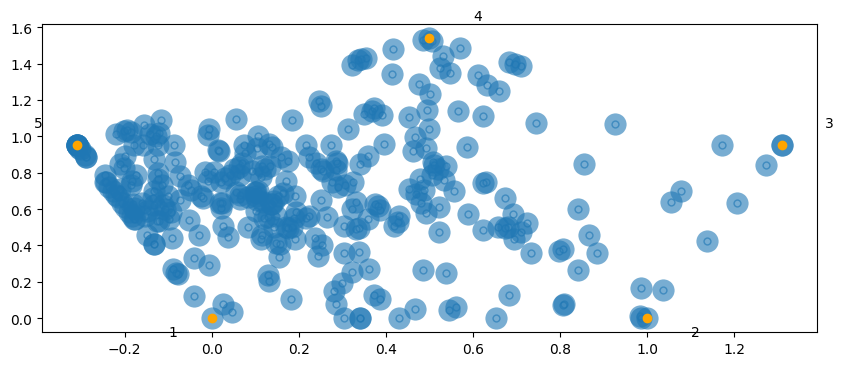

In [ ]:
A=archs.transform(intact_array[0].T)
dp=archs.map2D
dat=dp @ A

f, ax = plt.subplots(figsize=(10, 4))
ax=archetypal_plot(ax,dat,dp,epsilon=.1)
ax.set_aspect('auto')
plt.show()

In [ ]:
times_arch_1 = archs.A_[0]>.75

In [ ]:
times_arch_1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

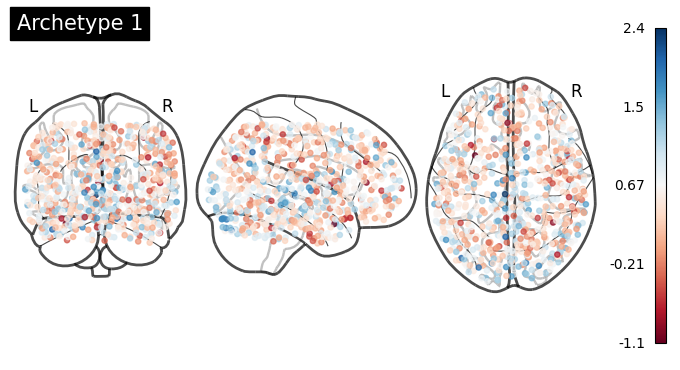

In [ ]:
nl.plotting.plot_markers(
    Z[:, 0],
    centers,
    title="Archetype 1",
    node_cmap=cm.RdBu,
)

In [ ]:
times_arch_2 = archs.A_[1]>.75

In [ ]:
times_arch_2

array([ True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

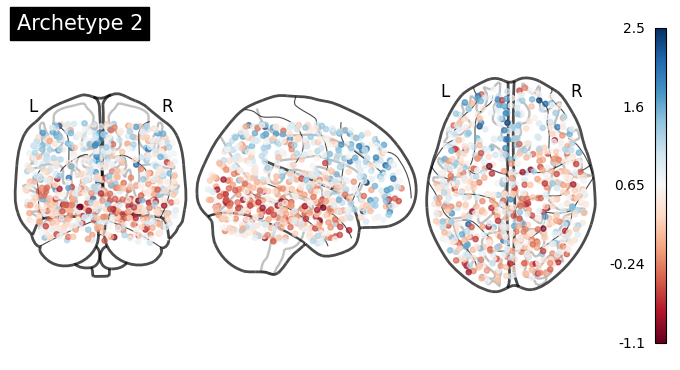

In [ ]:
nl.plotting.plot_markers(
    Z[:, 1],
    centers,
    title="Archetype 2",
    node_cmap=cm.RdBu,
)

In [ ]:
times_arch_3 = archs.A_[2]>.75

In [ ]:
times_arch_3

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

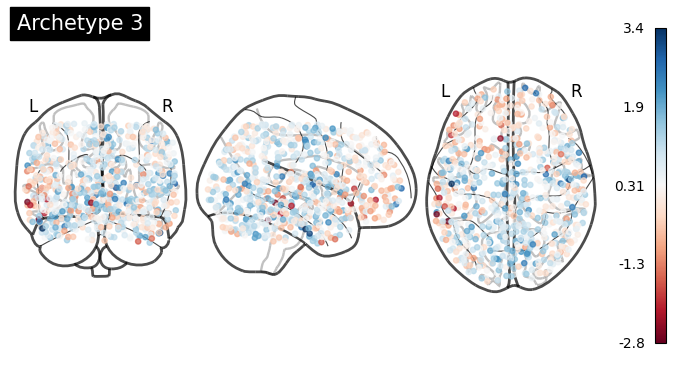

In [ ]:
nl.plotting.plot_markers(
    Z[:, 2],
    centers,
    title="Archetype 3",
    node_cmap=cm.RdBu,
)

In [ ]:
times_arch_4 = archs.A_[3]>.7

In [ ]:
times_arch_4

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

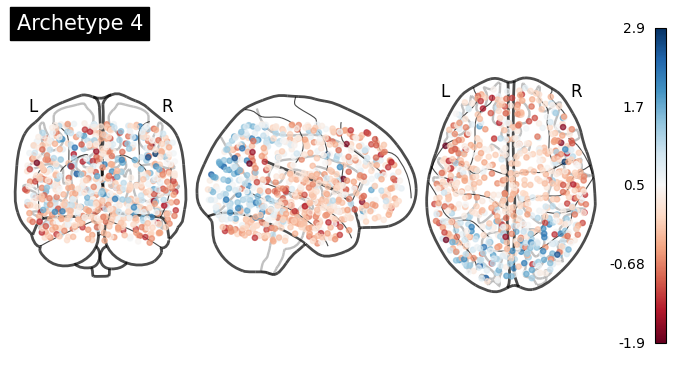

In [ ]:
nl.plotting.plot_markers(
    Z[:, 3],
    centers,
    title="Archetype 4",
    node_cmap=cm.RdBu,
)

In [ ]:
times_arch_5 = archs.A_[4]>.75

In [ ]:
times_arch_5

array([False, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True,  True,
       False, False,

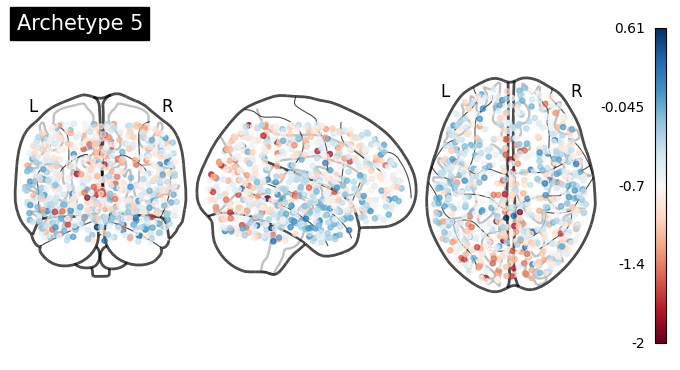

In [ ]:
nl.plotting.plot_markers(
    Z[:, 4],
    centers,
    title="Archetype 5",
    node_cmap=cm.RdBu,
)

### Ok now what about across participants??

In [ ]:
intact_array

array([[[ 0.86002639,  0.0504506 ,  0.44193355, ...,  2.2364127 ,
          1.90083687, -0.54789545],
        [ 1.15798977,  0.3911441 , -2.09692154, ...,  1.90107118,
          4.09946925, -0.97704309],
        [ 2.51845202,  0.35104619, -2.09971427, ...,  1.31928778,
          2.29581878, -1.05497914],
        ...,
        [-0.05783029,  0.40186573, -0.64830814, ...,  0.95281121,
          0.66117743, -1.12818568],
        [ 0.63797543,  1.2172146 , -1.42308967, ...,  1.77351663,
         -0.45300959, -0.65450354],
        [-0.91507128,  0.03718218, -0.94379748, ...,  1.43874632,
         -1.30591732,  0.24972308]],

       [[-1.5541844 ,  0.06085483, -0.68790086, ..., -2.71061319,
          0.06173995,  0.10120613],
        [-0.13942399, -0.95083388, -0.34867731, ..., -2.85443937,
         -1.17052946,  0.44760893],
        [ 0.83575168,  0.34209803,  1.65007638, ..., -1.45526895,
         -0.46866893,  0.60238898],
        ...,
        [ 0.99243758,  0.61044568,  0.98025814, ...,  

In [ ]:
# Reshape data
data_reshaped = intact_array.reshape(-1, intact_array.shape[0])

In [ ]:
intact_array.shape

(36, 300, 700)

In [ ]:
data_reshaped.shape

(210000, 36)

RSS = 2725.26775141121
RSS = 2714.8466238063806
RSS = 2684.9581578204297
RSS = 2652.3105788442226
RSS = 2641.828462528755
RSS = 2639.892112458292
RSS = 2639.1609465126676
RSS = 2638.8117623338185
RSS = 2638.6680702611266
RSS = 2638.5813737713747


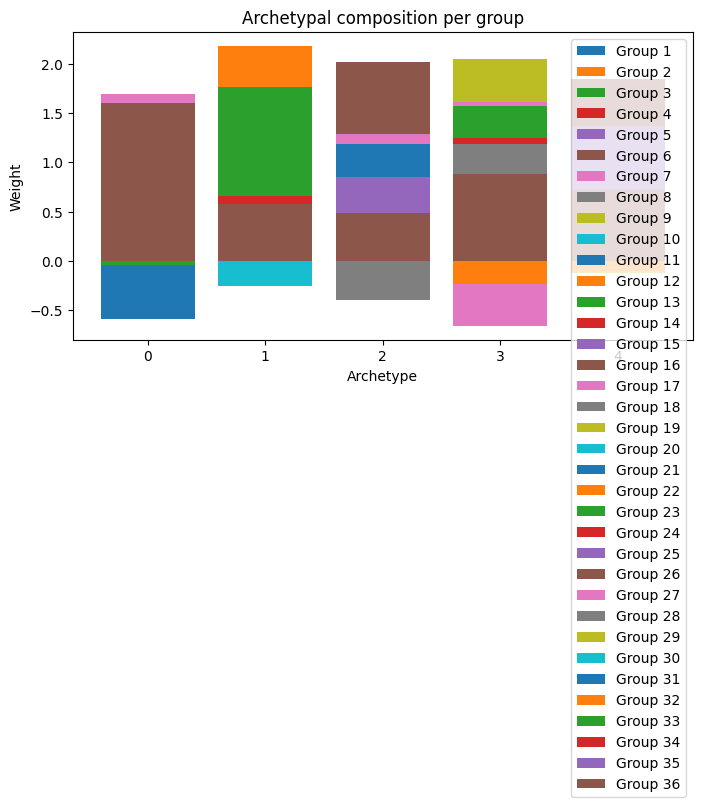

In [ ]:
data_reshaped = intact_array.reshape(-1, intact_array.shape[0])

archs = ArchetypalAnalysis(n_archetypes=5,iterations=10,tmax=300) #only doing 10 iterations now to save on time

archs.fit(data_reshaped)

# Get the archetypes and coefficients
archetypes = archs.transform(data_reshaped)  # shape: (5, 50)
coeffs = archs.archetypes()           # shape: (n_samples, 5)


plt.figure(figsize=(8, 4))
for i in range(data_reshaped.shape[1]):
    plt.bar(range(5), coeffs[i], label=f'Group {i+1}')
plt.xlabel("Archetype")
plt.ylabel("Weight")
plt.title("Archetypal composition per group")
plt.legend()
plt.show()


In [ ]:
intact_array.shape

(36, 300, 700)

RSS = 187.06256846769352
RSS = 180.59080118388752
RSS = 178.9000421495064
RSS = 178.15029514867658
RSS = 177.66797646322127
RSS = 177.3479391986884
RSS = 177.14218299360058
RSS = 176.9857071903216
RSS = 176.8365016357183
RSS = 176.67290398211955


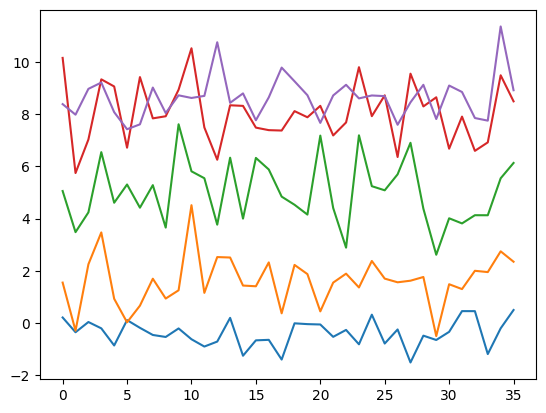

In [ ]:
archs = ArchetypalAnalysis(n_archetypes=5,iterations=10,tmax=300)

archs.fit(intact_array[:, 0, :])

Z=(archs.archetypes())

for i in np.arange(5):
  plt.plot(Z[:, i]+ 2*i)

In [ ]:
archs.A_[0].shape

(700,)

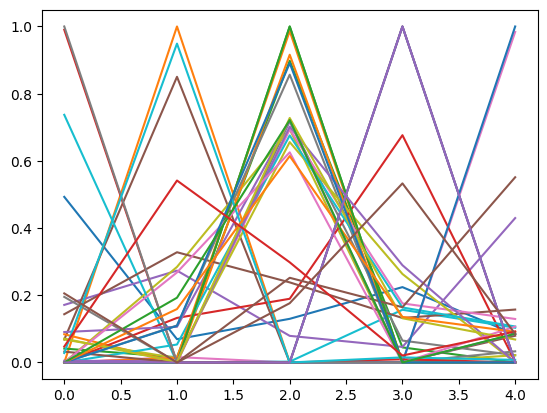

In [ ]:
plt.plot(archs.A_)

In [ ]:
centers.shape

(700, 3)

In [ ]:
locs_arch_try = archs.A_[0]>.7
arch_try_centers = centers[locs_arch_try]
arch_try_codes = node_codes['code'][locs_arch_try]
arch_try_nets = node_codes['Network'][locs_arch_try]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 700 but corresponding boolean dimension is 36

In [ ]:
nl.plotting.plot_connectome(np.eye(arch_try_centers.shape[0]), arch_try_centers, node_size=10, node_color=[colors[i] for i in arch_try_codes], display_mode='lyrz')

In [ ]:
data_list = [data[i] for i in np.arange(125)]

In [ ]:
data_array = np.array(data_list)

<ipython-input-261-86569ece3214>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(data_list)


In [ ]:
data_array

(125,)

In [ ]:
data_array = np.array(data)

<ipython-input-253-36e6c6b8505d>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  data_array = np.array(data)


In [ ]:
data_array[]

(300, 700)